In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP
from scipy.sparse import csr_matrix
from umap_batch import UMAP
from umap_batch import re_pairdis
from umap.utils import fast_knn_indices

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model_refine
import time

import quantile 

import coupleNMF as coupleNMF
from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [2]:
dir = '../data/real/hori/Pancreas/'

counts_rnas = []
counts_atacs = []
for batch in range(8):
    counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
    # preprocess the count matrix
    counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    counts_rnas.append(counts_rna)

counts = {"rna":counts_rnas}


# obtain the feature name
genes = pd.read_csv(dir + "gene.csv", header = None).values.squeeze()
feats_name = {'rna': genes}
counts["feats_name"] = feats_name

interacts = None

In [11]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
K = 30
Ns = [K] * 8
N_feat = Ns[0]
interval = 100
T = 6000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model_refine.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

Input sanity check...
Finished.
loss1_sub: 2.2733e-02
loss1_sub: 1.9539e-02
loss1_sub: 3.9183e-02
loss1_sub: 3.8297e-02
loss1_sub: 1.7345e-02
loss1_sub: 1.7989e-02
loss1_sub: 1.5223e-02
loss1_sub: 2.0570e-02
Epoch 100, Validating Loss: 192.2370
	 loss 1: 0.19088
	 loss 2: 1.35936
	 loss 3: 0.00000
loss1_sub: 2.2550e-02
loss1_sub: 1.9193e-02
loss1_sub: 3.8670e-02
loss1_sub: 3.7332e-02
loss1_sub: 1.7280e-02
loss1_sub: 1.7916e-02
loss1_sub: 1.5168e-02
loss1_sub: 2.0462e-02
Epoch 200, Validating Loss: 188.5700
	 loss 1: 0.18857
	 loss 2: 0.00000
	 loss 3: 0.00000
loss1_sub: 2.2114e-02
loss1_sub: 1.8455e-02
loss1_sub: 3.8029e-02
loss1_sub: 3.5747e-02
loss1_sub: 1.7131e-02
loss1_sub: 1.7743e-02
loss1_sub: 1.5029e-02
loss1_sub: 2.0229e-02
Epoch 300, Validating Loss: 184.4767
	 loss 1: 0.18448
	 loss 2: 0.00013
	 loss 3: 0.00000
loss1_sub: 2.1742e-02
loss1_sub: 1.7903e-02
loss1_sub: 3.7587e-02
loss1_sub: 3.4705e-02
loss1_sub: 1.6998e-02
loss1_sub: 1.7597e-02
loss1_sub: 1.4900e-02
loss1_sub: 2.

loss1_sub: 2.0297e-02
loss1_sub: 1.6343e-02
loss1_sub: 3.5969e-02
loss1_sub: 3.1905e-02
loss1_sub: 1.6399e-02
loss1_sub: 1.6947e-02
loss1_sub: 1.4360e-02
loss1_sub: 1.9117e-02
Epoch 3200, Validating Loss: 171.3404
	 loss 1: 0.17134
	 loss 2: 0.00341
	 loss 3: 0.00000
loss1_sub: 2.0293e-02
loss1_sub: 1.6338e-02
loss1_sub: 3.5971e-02
loss1_sub: 3.1887e-02
loss1_sub: 1.6394e-02
loss1_sub: 1.6943e-02
loss1_sub: 1.4357e-02
loss1_sub: 1.9109e-02
Epoch 3300, Validating Loss: 171.2941
	 loss 1: 0.17129
	 loss 2: 0.00273
	 loss 3: 0.00000
loss1_sub: 2.0281e-02
loss1_sub: 1.6328e-02
loss1_sub: 3.5939e-02
loss1_sub: 3.1865e-02
loss1_sub: 1.6384e-02
loss1_sub: 1.6935e-02
loss1_sub: 1.4350e-02
loss1_sub: 1.9109e-02
Epoch 3400, Validating Loss: 171.1950
	 loss 1: 0.17119
	 loss 2: 0.00440
	 loss 3: 0.00000
loss1_sub: 2.0269e-02
loss1_sub: 1.6326e-02
loss1_sub: 3.5946e-02
loss1_sub: 3.1859e-02
loss1_sub: 1.6381e-02
loss1_sub: 1.6931e-02
loss1_sub: 1.4347e-02
loss1_sub: 1.9103e-02
Epoch 3500, Validati

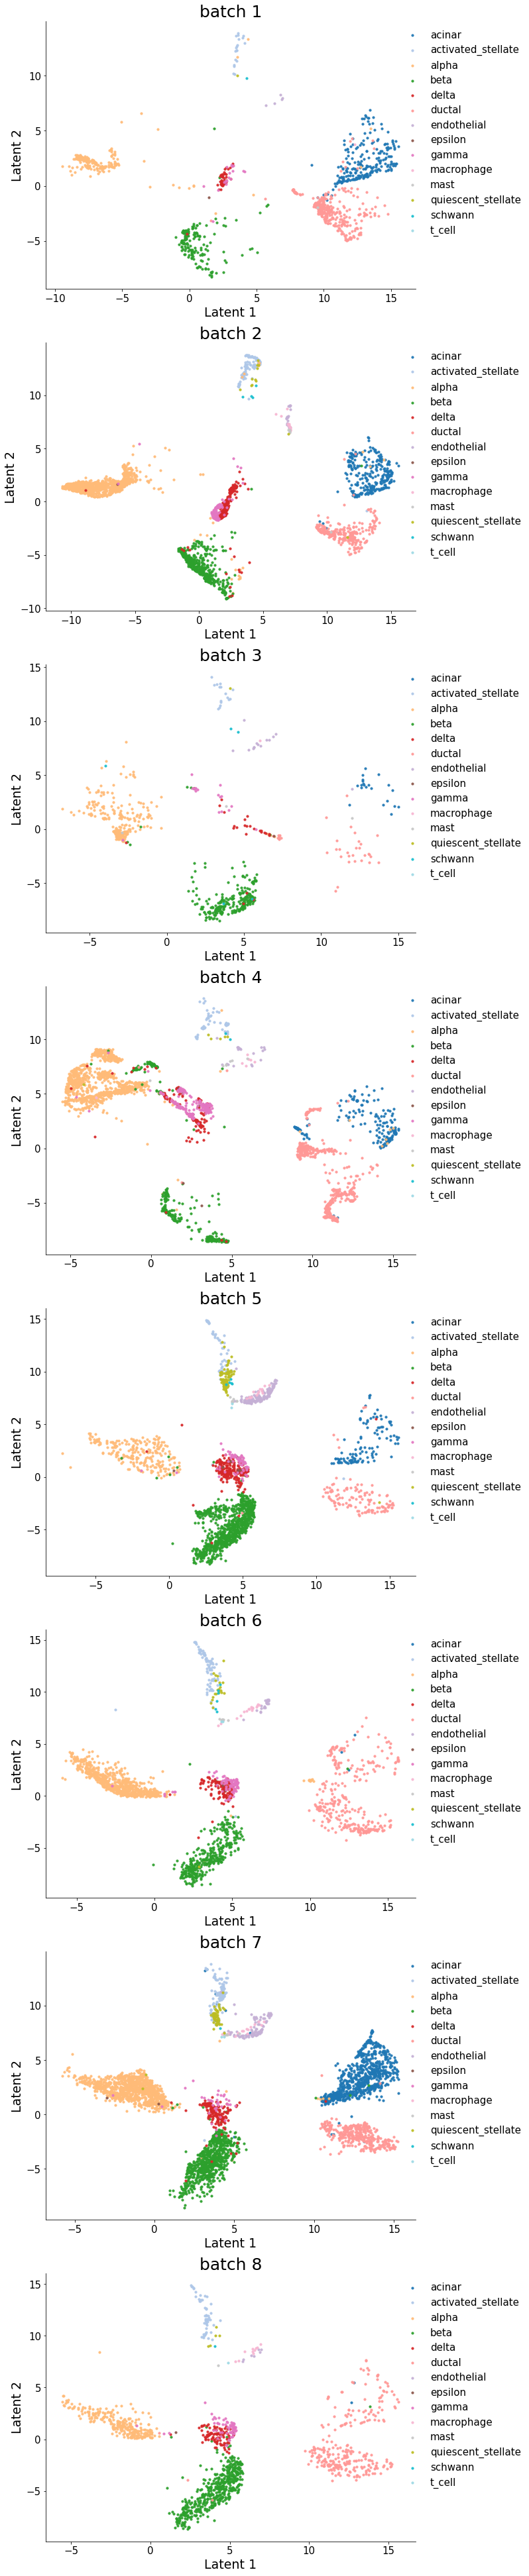

In [19]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")


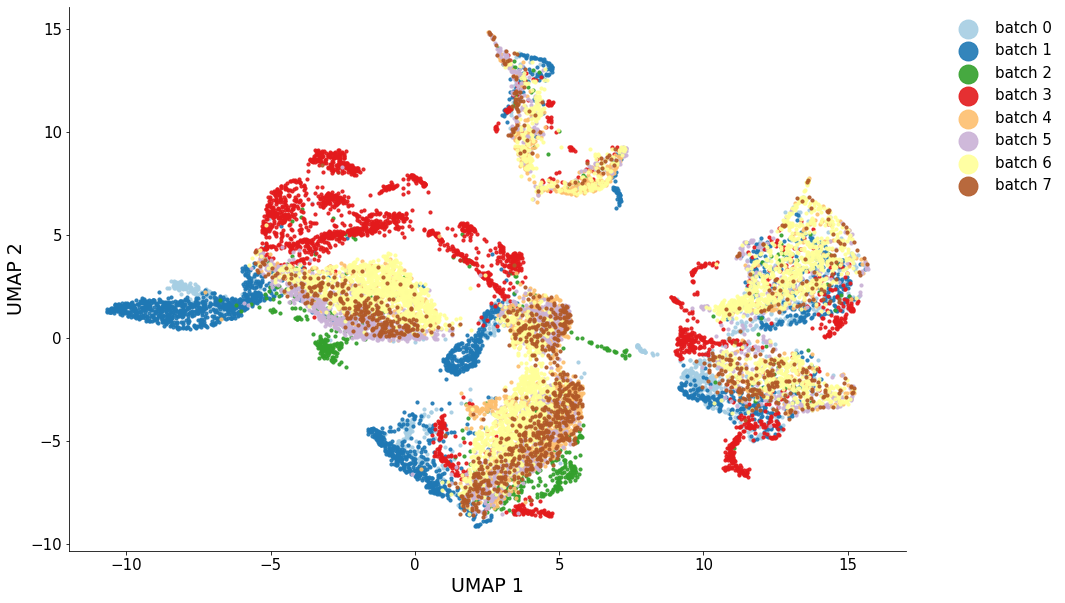

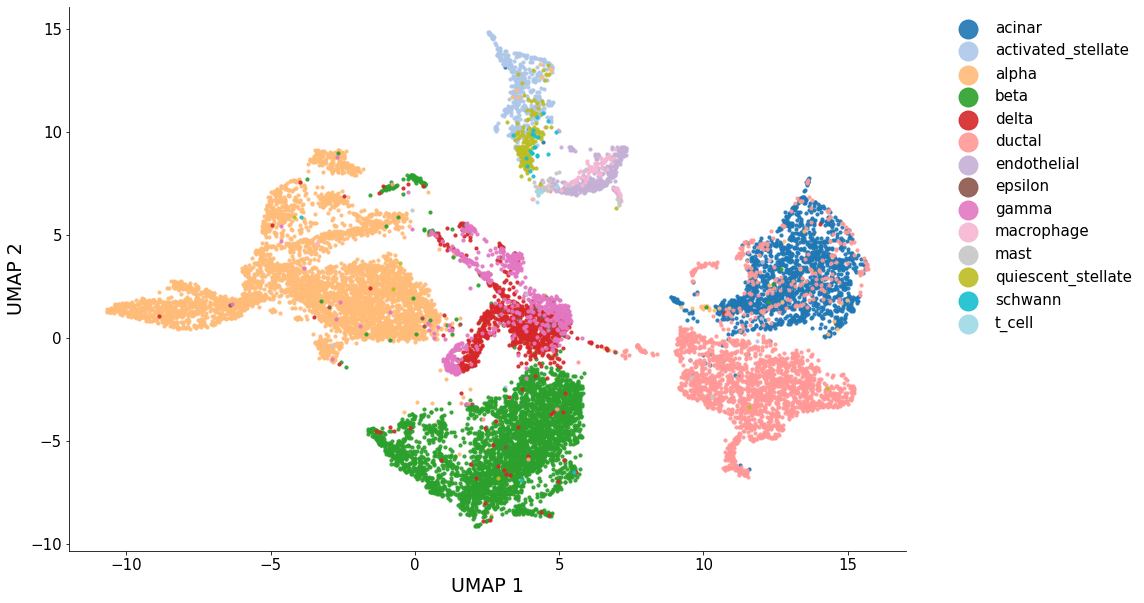

In [26]:
save_file = "pancreas/umap_batches.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

save_file = "./pancreas/umap_celltypes.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


In [27]:
# scDART flavor

zs = []
labels = []
pre_labels = []
for batch in range(8):

    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

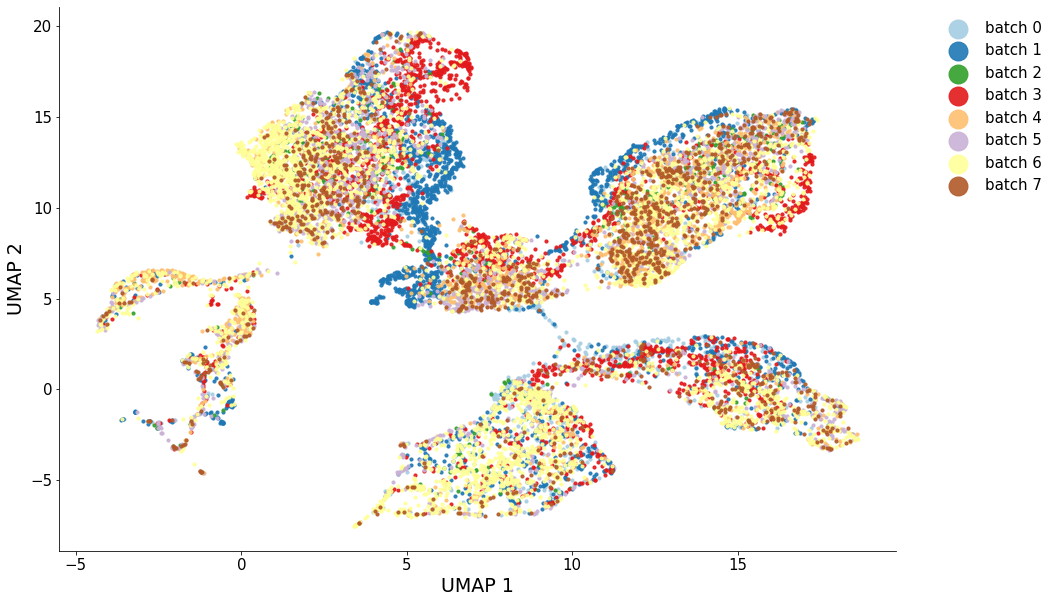

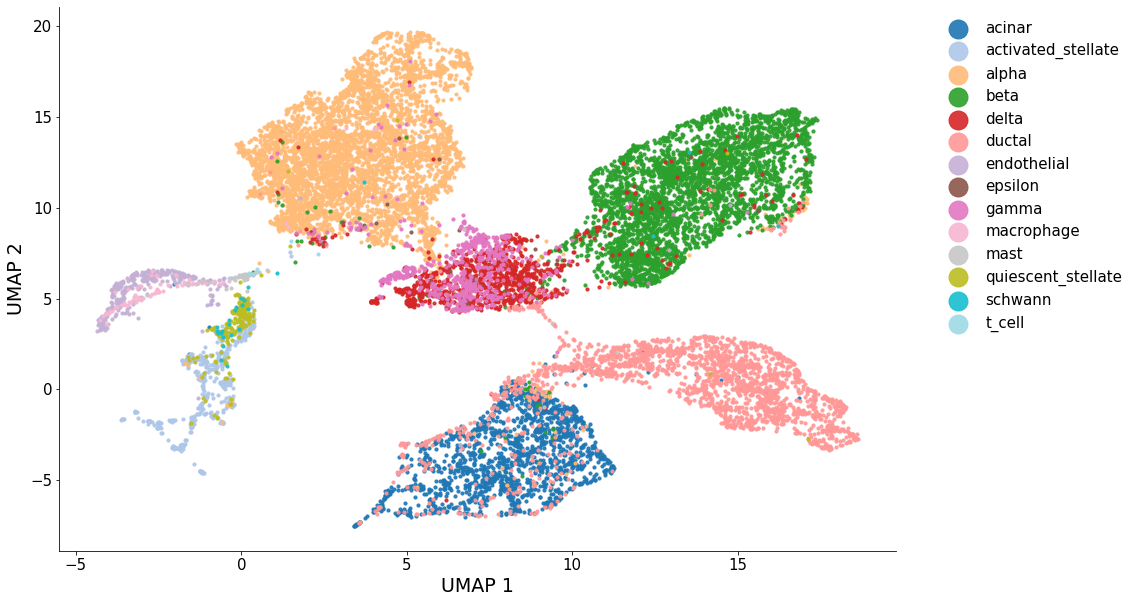

In [28]:
save_file = "pancreas/umap_batches_scDART_post.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

save_file = "./pancreas/umap_celltypes_scDART_post.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


In [ ]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1,
             start_point[maxbatch]:end_point[maxbatch]+1].flatten()

# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p, 1)
p += p.T
s_pair_dist = csr_matrix(p)

aft_mean = np.zeros((len(zs), len(zs)))

for row in range(len(zs)):
    for col in range(len(zs)):
        block = p[start_point[row]:end_point[row]+1, start_point[col]:end_point[col]+1]
        mean = np.mean(block)
        aft_mean[row, col] = mean

aft_mean

# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 15

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)

knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1], b_neighbors[batch]) \
                + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()
umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)

x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")

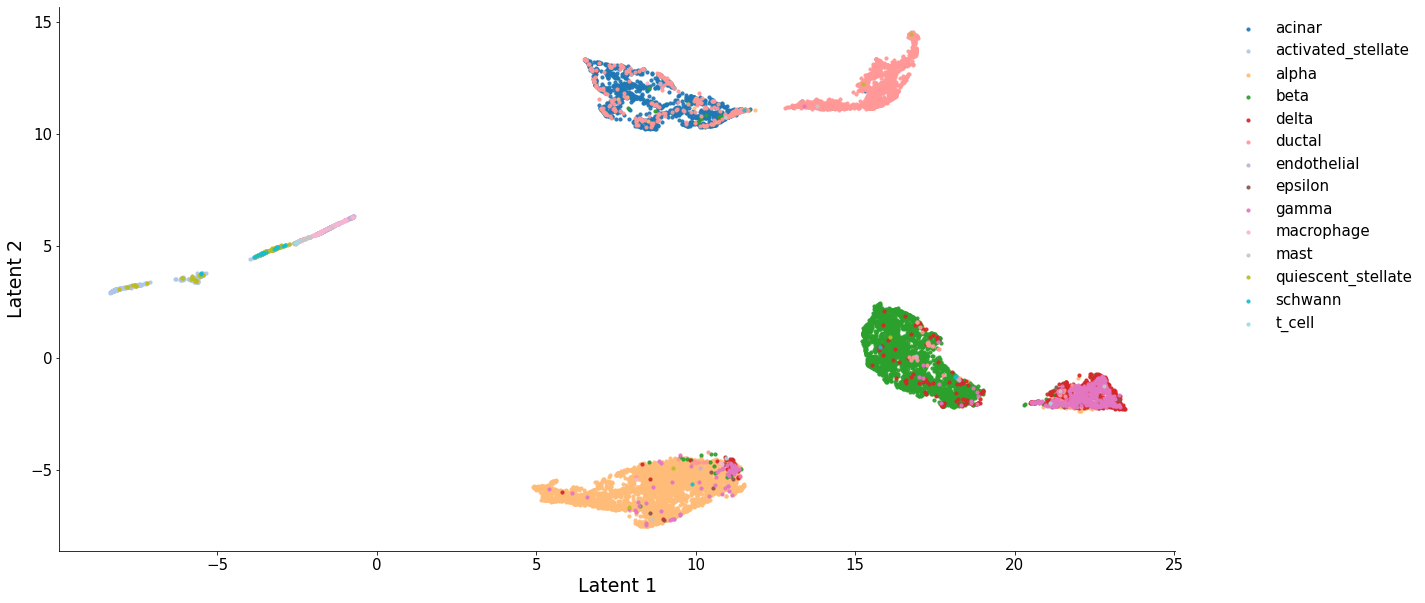

In [18]:
save_file = "pancreas/umap_batches_umap_post.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

save_file = "./pancreas/umap_celltypes_umap_post.png"
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


## Old model

In [3]:
aris = np.load("../test/results_pancreas_dims/aris.npy")
aris = pd.DataFrame(data = aris.reshape(3,6), columns = [10, 13, 15, 17, 20, 30], index = ["lr = 1e-2, T = 4000", "lr = 5e-3, T = 4000", "lr = 5e-3, T = 10000"])
print("batchsize: 0.1")
display(aris)

aris = np.load("../test/results_pancreas_dims/aris2.npy")
aris = pd.DataFrame(data = aris.reshape(3,6), columns = [10, 13, 15, 17, 20, 30], index = ["lr = 1e-2, T = 4000", "lr = 5e-3, T = 4000", "lr = 5e-3, T = 10000"])
print("batchsize: 0.3")
display(aris)

batchsize: 0.1


10        13        15        17        20  \
lr = 1e-2, T = 4000   0.122560  0.304848  0.120896  0.341928  0.149149   
lr = 5e-3, T = 4000   0.308299  0.413085  0.499109  0.482075  0.315545   
lr = 5e-3, T = 10000  0.174625  0.205422  0.224609  0.233625  0.228969   

                            30  
lr = 1e-2, T = 4000   0.314376  
lr = 5e-3, T = 4000   0.255524  
lr = 5e-3, T = 10000  0.190970

batchsize: 0.3


10        13        15        17        20  \
lr = 1e-2, T = 4000   0.383205  0.359334  0.198245  0.548635  0.322396   
lr = 5e-3, T = 4000   0.378293  0.288292  0.471852  0.470777  0.249225   
lr = 5e-3, T = 10000  0.214055  0.186591  0.355478  0.279223  0.294590   

                            30  
lr = 1e-2, T = 4000   0.160473  
lr = 5e-3, T = 4000   0.276281  
lr = 5e-3, T = 10000  0.310628

In [16]:
# train model
# last one is the one fit into the original model
alpha = [1000, 1, 100, 100, 0.00]
#hyper parameters
batchsize = 0.1
lr = 5e-3
run = 0

Ns = [10] * 8
K = 10
N_feat = Ns[0] + 1

model1 = model.cfrm_new2(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, 
                         batch_size = batchsize, interval=1000, lr=lr, alpha =alpha, seed = run).to(device)
losses = model1.train_func(T = 4000)

Input sanity check...
Finished.
Epoch 1000, Validating Loss: 179.6833
	 loss 1: 179.68327
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 2000, Validating Loss: 173.6104
	 loss 1: 173.61037
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 3000, Validating Loss: 172.2640
	 loss 1: 172.26401
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 4000, Validating Loss: 171.3134
	 loss 1: 171.31337
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000


In [17]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


In [18]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

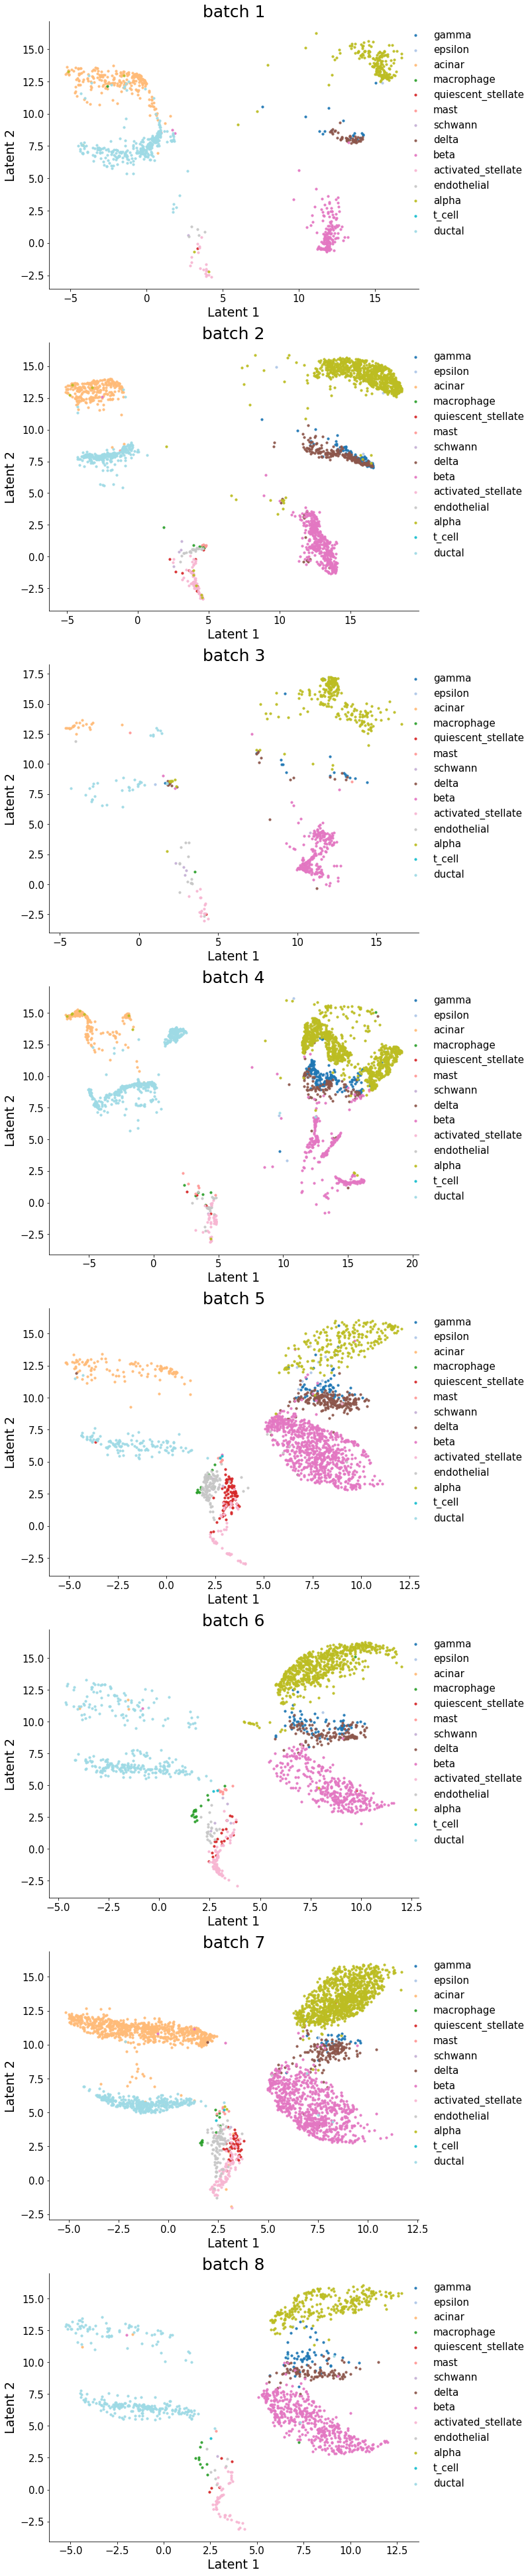

In [19]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")


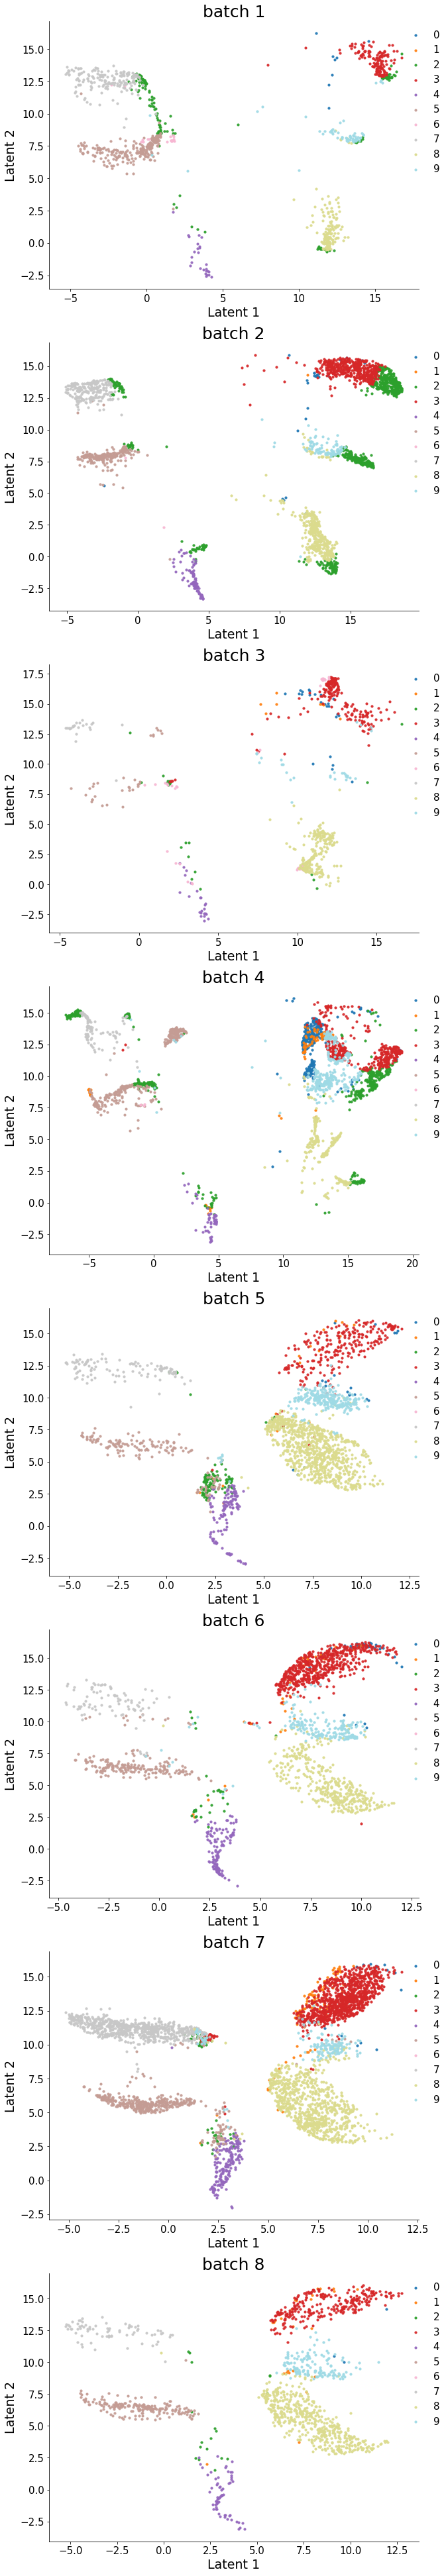

In [20]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")


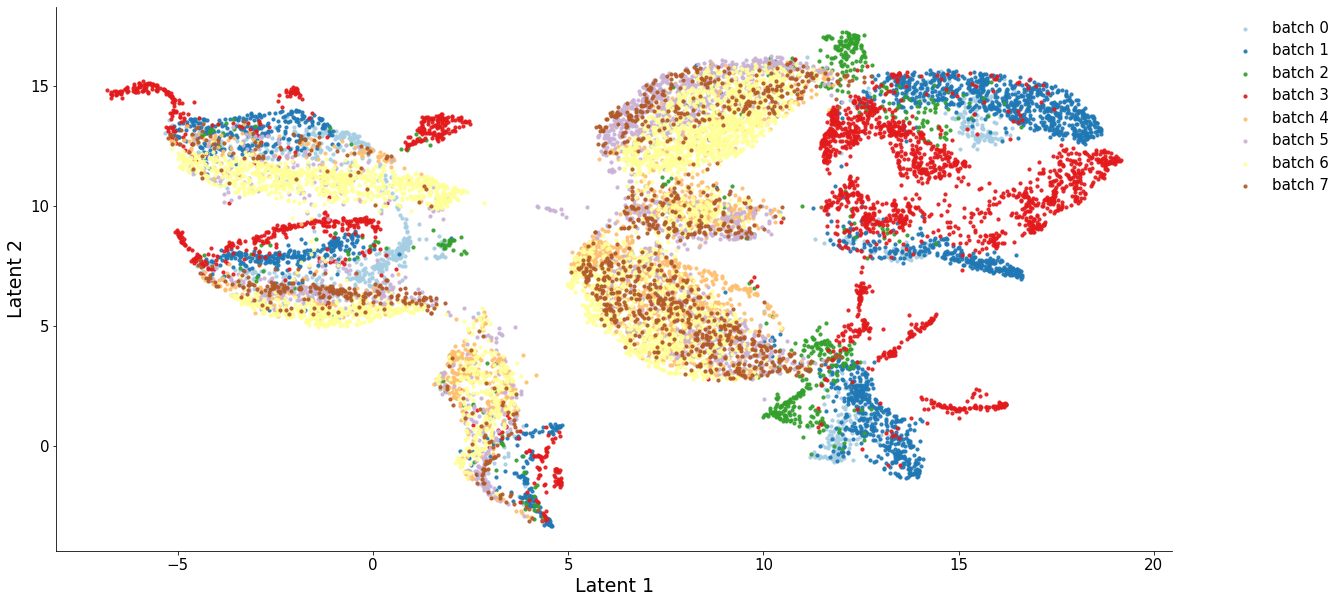

In [21]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


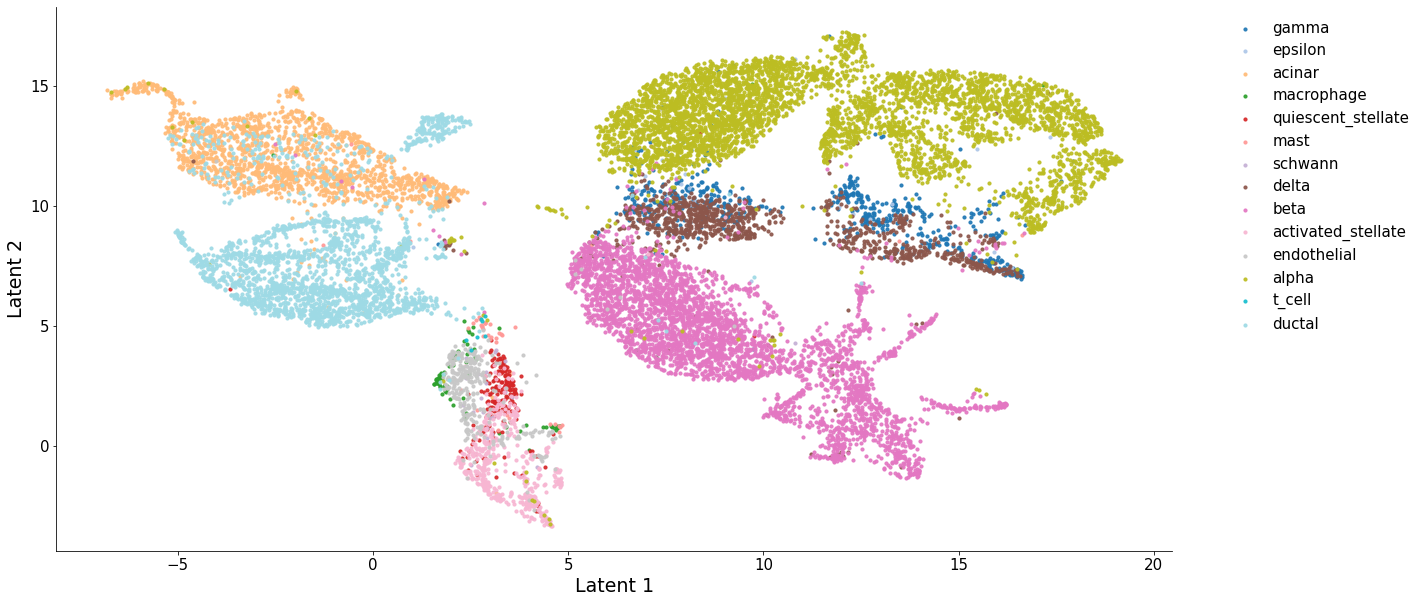

In [22]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


## Post-processing

In [23]:
"""
# Quantile normalization, result not good

zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

zs2 = quantile.quantile_norm(zs)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

# scDART, match clusters

zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds_clust(zs, k = 10, reference = None, bandwidth = 1)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")
"""

'\n# Quantile normalization, result not good\n\nzs = []\nlabels = []\npre_labels = []\nfor batch in range(8):\n    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()\n    zs.append(z)\n    labels.append(pd.read_csv(os.path.join(dir, \'meta_c\' + str(batch) + \'.csv\'), index_col=0)["celltype"].values.squeeze())\n    pre_labels.append(np.argmax(z, axis = 1).squeeze())\n\nzs2 = quantile.quantile_norm(zs)\n\nx_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))\n# separate into batches\nx_umaps = []\nfor batch in range(8):\n    if batch == 0:\n        start_pointer = 0\n        end_pointer = start_pointer + zs2[batch].shape[0]\n        x_umaps.append(x_umap[start_pointer:end_pointer,:])\n    elif batch == 7:\n        start_pointer = start_pointer + zs2[batch - 1].shape[0]\n        x_umaps.append(x_umap[start_pointer:,:])\n    else:\n        start_pointer = start_pointer + zs2[batch - 1].shape[0]\n        end_pointer = start_pointer + zs2[batch].shape[0]\n        x_um

In [24]:
# scDART flavor

zs = []
labels = []
pre_labels = []
for batch in range(8):

    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

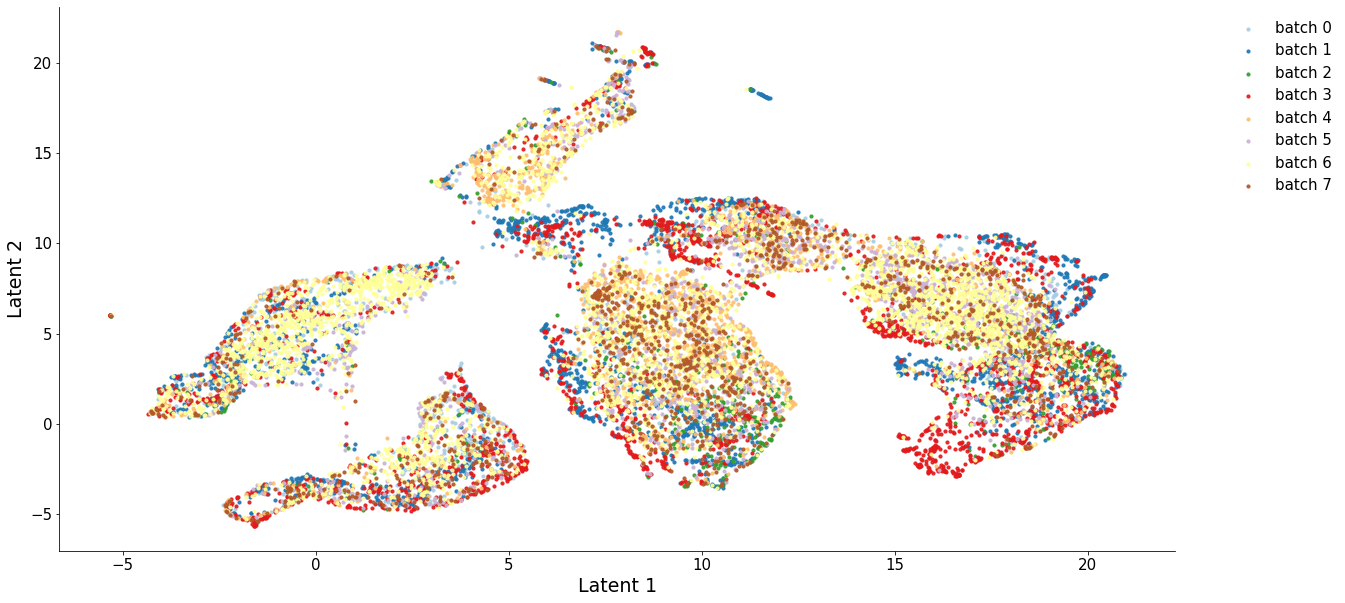

In [25]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


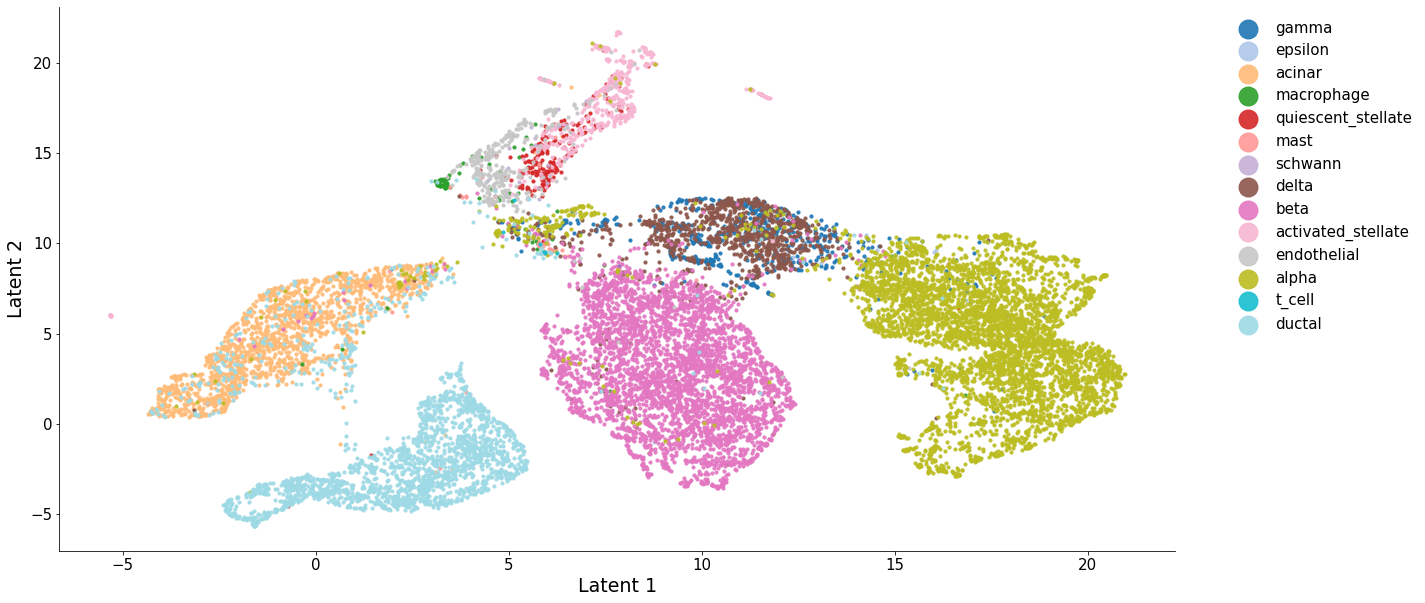

In [26]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = "pancreas/umap_joint.png", 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


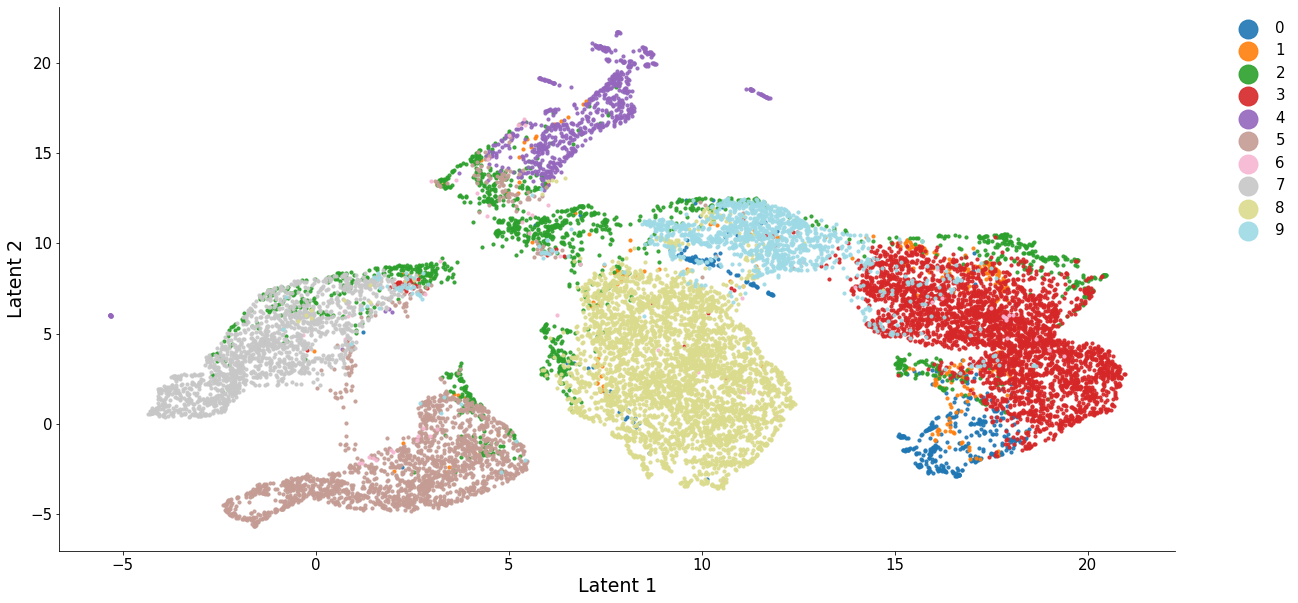

In [27]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = "pancreas/umap_joint_pred.png", 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


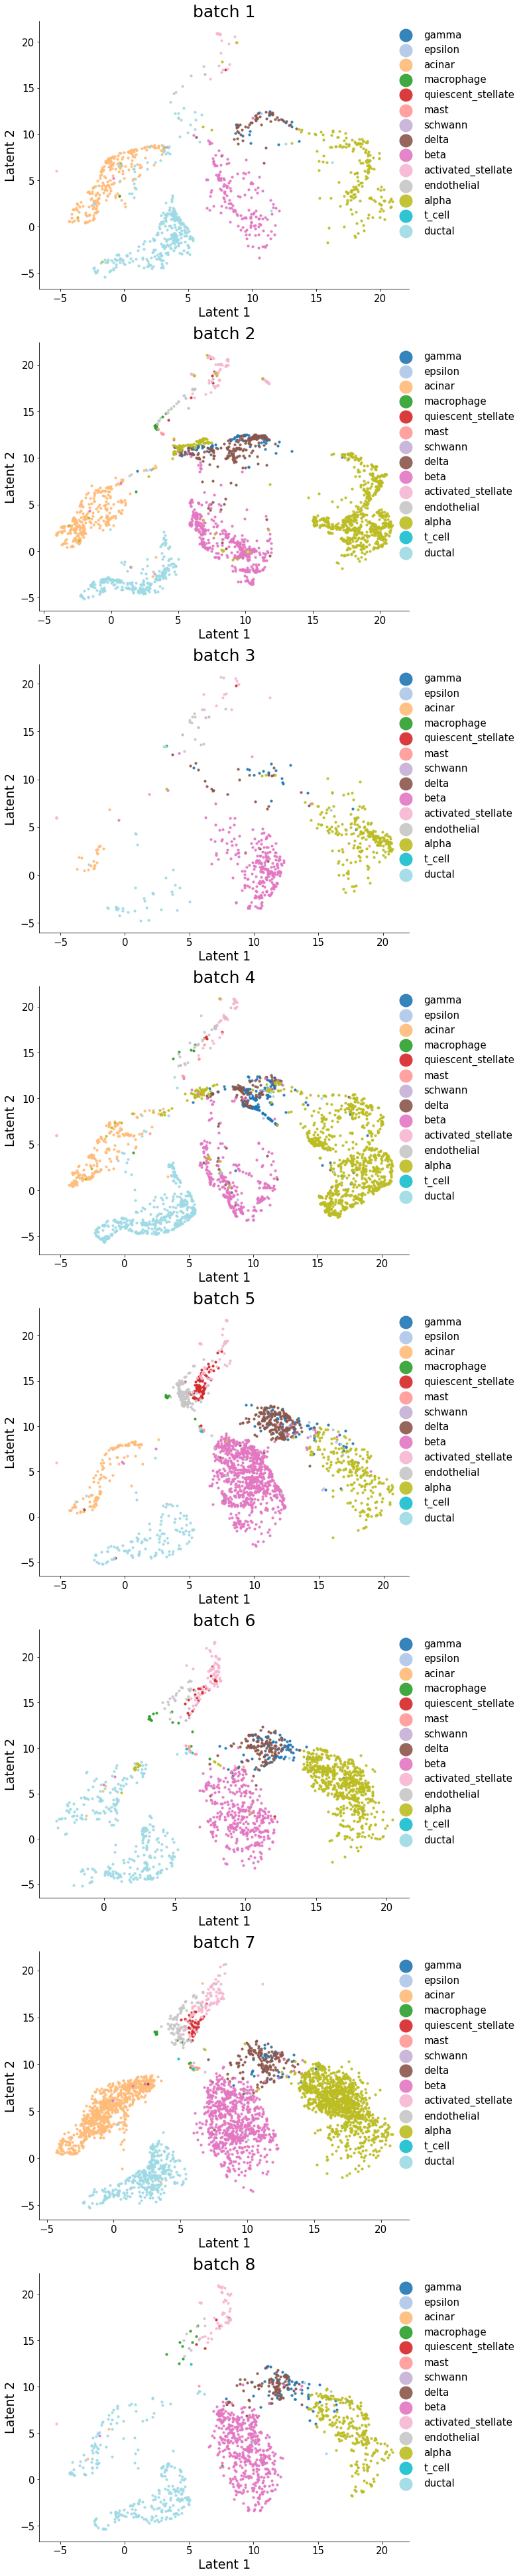

In [28]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = "pancreas/umap_separate.pdf", 
                      figsize = (10,70), axis_label = "Latent", markerscale = 6)


## Analyzing the DE genes

Markers for the acinar cell type (factor 7), include `CPA1`(baron paper, Fig. 2a), `REG1A` (https://satijalab.org/seurat/archive/v3.0/integration.html), 

Markers for the beta cell type (factor 8), include `INS` and `IAPP` (baron paper, Fig. 2a) are found in the factor 8.

Markers for the alpha cell type (factor 1, and 3), include `TM4SF4`, `GCG`, `LOLX4`,`IRX2`, `ARX`,`TTR` (A Single-Cell Transcriptome Atlas of the Human Pancreas, abstract, Fig. 1E) is found in factor 1 and factor 3. Difference between factor 1 and factor 3.

Markers for the delta cell type (factor 9, very well mixed with factor 8 beta-cell), not found yet.

Markers for the ductal cell type (factor 5), include `SPP1`, `CFTR`, `MMP7`, `TSPAN8`. (A Single-Cell Transcriptome Atlas of the Human Pancreas, abstract, Fig. S1I)




In [29]:
# output de feature list (hard method):
#
# 1. select the feature factors that associated with each cell factor, according to the association matrix
# 2. select the features with high factor value for each feature factor.
# 3. combine 1 and 2 to select the features for each cell factor.
"""
de_feats = []
for mod in range(len(model1.binary_A_assos)):
    # create a de list for the current modality
    de_feats.append([])
    
    # extract the Association matrix
    binary_A_asso = model1.binary_A_assos[mod]
    A_asso = model1.A_assos[mod]
    
    # extract the feature factor
    binary_C_feat = model1.binary_C_feats[mod]
    C_feat = model1.softmax(model1.C_feats[mod])
    
    # number of cell clusters
    n_clusts = binary_A_asso.shape[0]
    
    for clust in range(n_clusts):
        de_feats[-1].append({})
        # select the feature cluster correspond to each cell cluster
        feat_clusts = np.where(binary_A_asso[clust,:] == True)[0]
        
        for feat_clust in feat_clusts:
            # select differentially expressed features for each corresponding feature cluster
            de_feat = [x for x in feats_name[mod][np.where(binary_C_feat[:,feat_clust] == True)[0]]]
            # scoring, consider both Association score and feature factor
            scores = [A_asso[clust, feat_clust].item() * x.item() for x in C_feat[np.where(binary_C_feat[:,feat_clust] == True)[0], feat_clust]]
            for i, feat in enumerate(de_feat):
                if feat in de_feats[-1][-1]:
                    # pass
                    de_feats[-1][-1][feat] += scores[i]
                else:
                    de_feats[-1][-1][feat] =  scores[i]
            
# save the result
for mod, de_feat in enumerate(de_feats):
    if not os.path.exists('pancreas/' + model1.mods[mod] + "_hard"):
        os.makedirs('pancreas/' + model1.mods[mod] + "_hard")
    for clust, de_feat_clust in enumerate(de_feat):
        de_feat_clust_df = pd.DataFrame.from_dict(de_feat_clust, orient = 'index', columns = ["score"]).sort_values(by = ["score"], ascending = False)
        de_feat_clust_df.to_csv('pancreas/' + model1.mods[mod] + "_hard/clust_" + str(clust) + ".csv")


de_feat = de_feats[0]
C_gene_hard = pd.DataFrame(data = 0, index = genes, columns = ["factor_" + str(x) for x in range(len(de_feat))])

for clust, de_feat_clust in enumerate(de_feat):
    de_feat_clust_df = pd.DataFrame.from_dict(de_feat_clust, orient = 'index', columns = ["score"])
    C_gene_hard.loc[de_feat_clust_df.index.values, ["factor_" + str(clust)]] += de_feat_clust_df.values

"""

C_gene_hard = model1.findMarkers(truncate = True)[0]

#     for clust in range(C_gene_hard.shape[1]):
#         factor = "factor_" + str(clust)
#         factor_values = C_gene_hard.loc[:, [factor]]
#         factor_values = factor_values.sort_values(by = factor, ascending = False)
#         factor_values = factor_values[factor_values > 0]
#         if not os.path.exists('pancreas/' + model1.mods[mod] + "_hard"):
#             os.makedirs('pancreas/' + model1.mods[mod] + "_hard")
#         factor_values.to_csv('pancreas/' + model1.mods[mod] + "_hard/clust_" + str(clust) + ".csv")

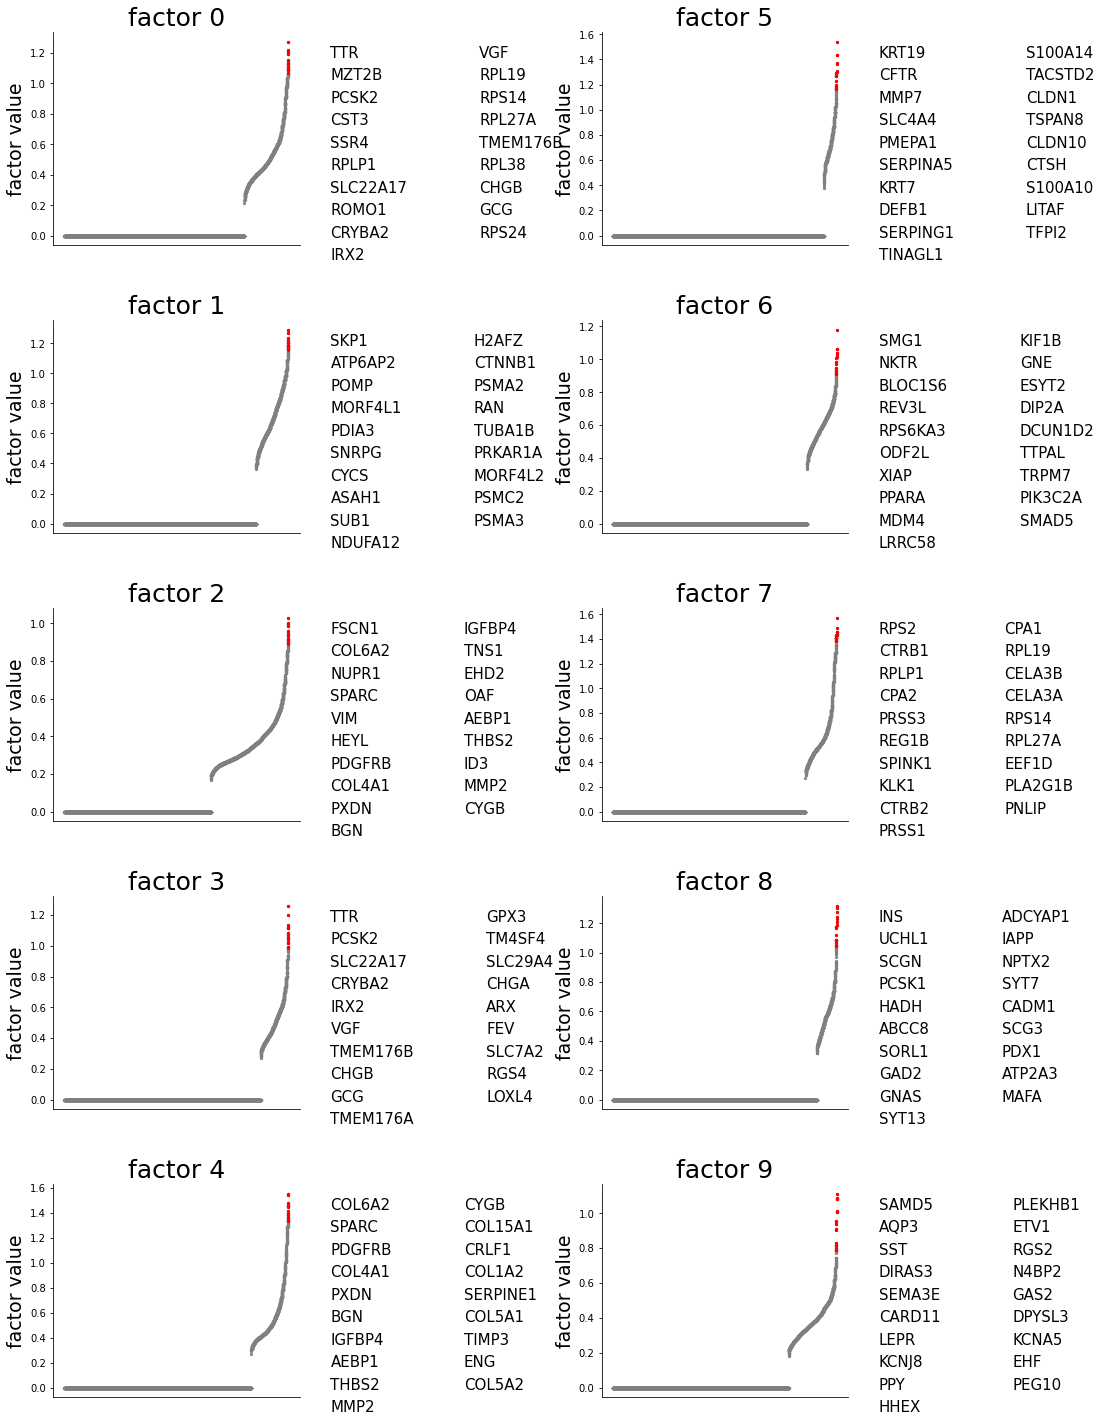

In [30]:
# plot the result from hard method
utils.plot_feat_score(C_gene_hard, n_feats = 20, figsize= (15,20), save_as = "pancreas/gene_factors_hard.png", title = None)

In [31]:
# output de feature list (soft method), multiply association matrix with feature factor matrix
C_gene = model1.findMarkers(truncate = False)[0]

# for clust in range(C_gene.shape[1]):
#     factor = "factor_" + str(clust)
#     factor_values = C_gene.loc[:, [factor]]
#     factor_values = factor_values.sort_values(by = factor, ascending = False)[:n_selected]
#     if not os.path.exists('pancreas/' + model1.mods[mod] + "_soft"):
#         os.makedirs('pancreas/' + model1.mods[mod] + "_soft")
#     factor_values.to_csv('pancreas/' + model1.mods[mod] + "_soft/clust_" + str(clust) + ".csv")

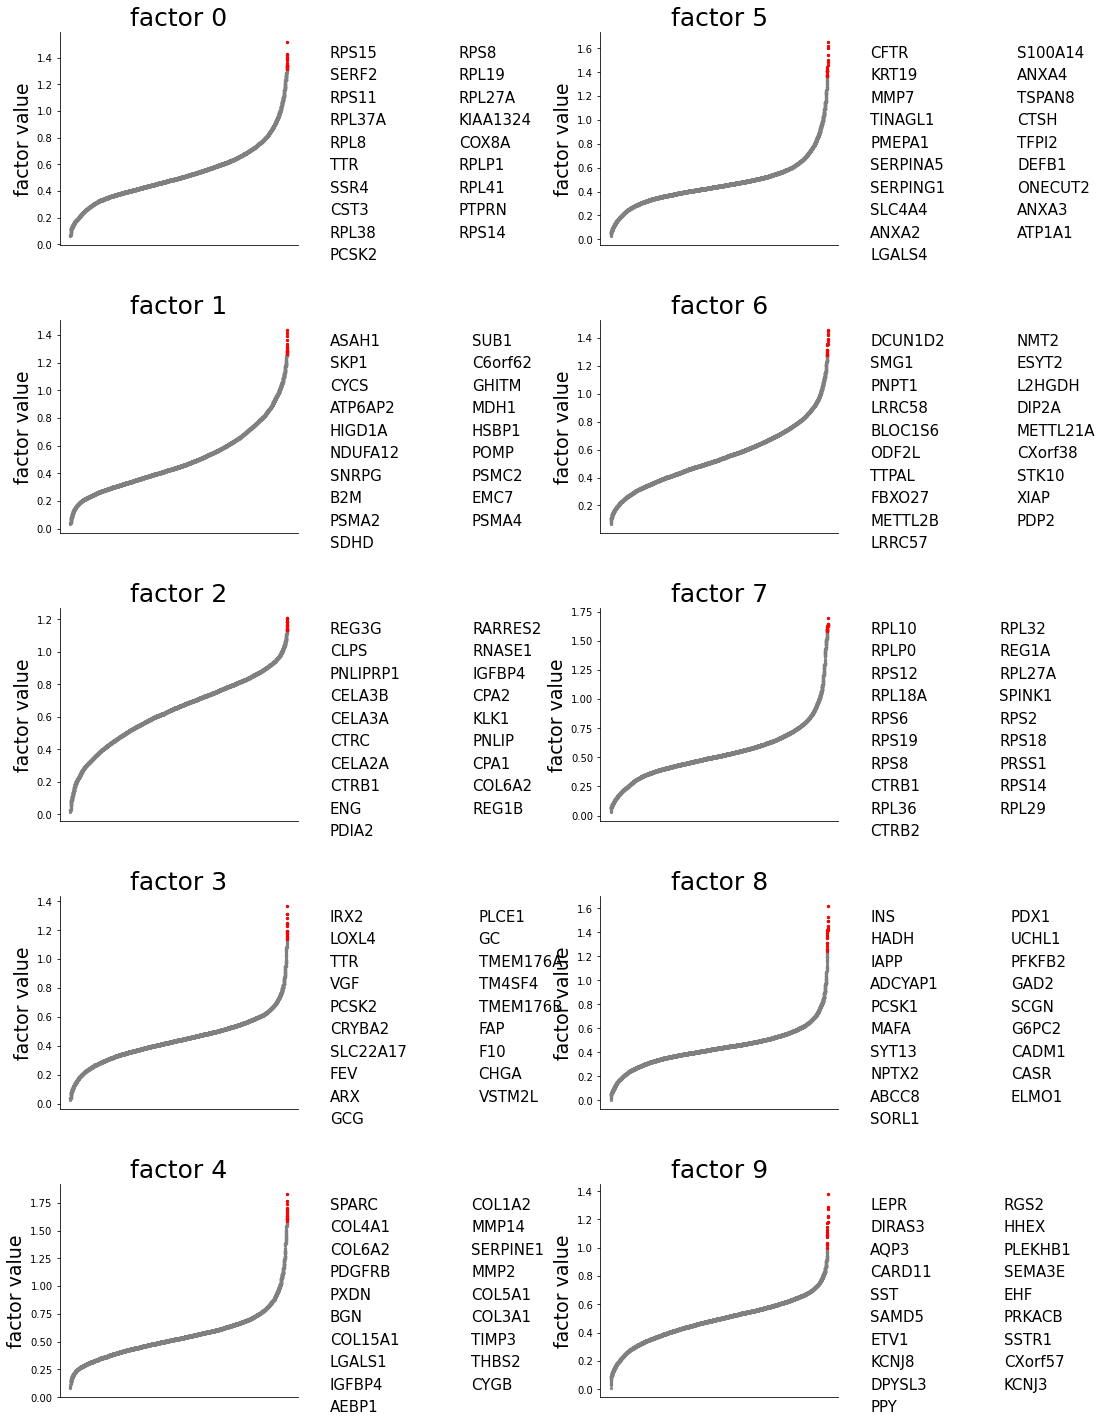

In [32]:
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,20), save_as = "pancreas/gene_factors_soft.png", title = None)


### Check marker genes of factor 7 (ACINAR cell type)

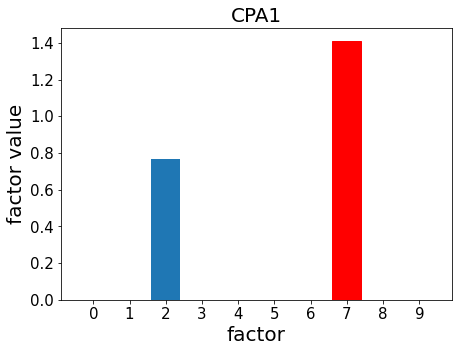

In [33]:
x_cpa1 = C_gene_hard.iloc[np.where(genes == "CPA1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[7].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("CPA1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/CPA1_hard.png", bbox_inches = "tight")

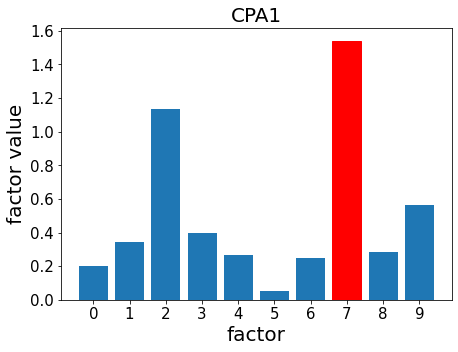

In [34]:
x_cpa1 = C_gene.iloc[np.where(genes == "CPA1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[7].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("CPA1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/CPA1.png", bbox_inches = "tight")

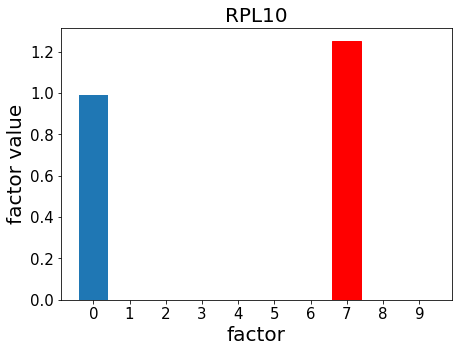

In [35]:
x_cpa1 = C_gene_hard.iloc[np.where(genes == "RPL10")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[7].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("RPL10", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/RPL10_hard.png", bbox_inches = "tight")

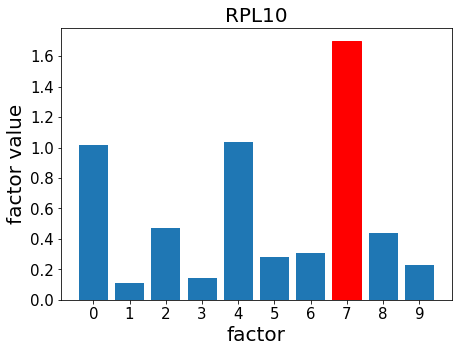

In [36]:
x_cpa1 = C_gene.iloc[np.where(genes == "RPL10")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[7].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("RPL10", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/RPL10.png", bbox_inches = "tight")

### Check marker genes for factor 2 (endothelial cell type)

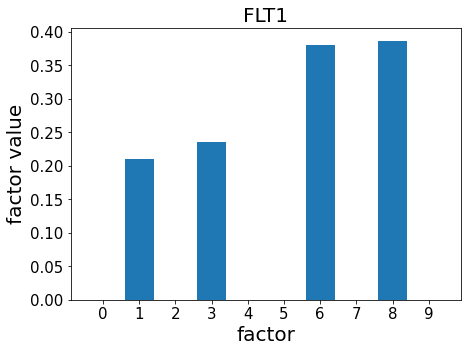

In [26]:
x_cpa1 = C_gene_hard.iloc[np.where(genes == "FLT1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[2].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("FLT1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/FLT1_hard.png", bbox_inches = "tight")

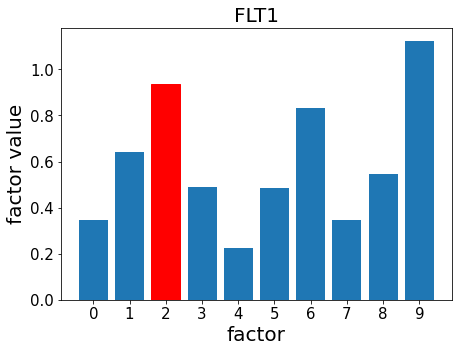

In [27]:
x_cpa1 = C_gene.iloc[np.where(genes == "FLT1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[2].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("FLT1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/FLT1.png", bbox_inches = "tight")

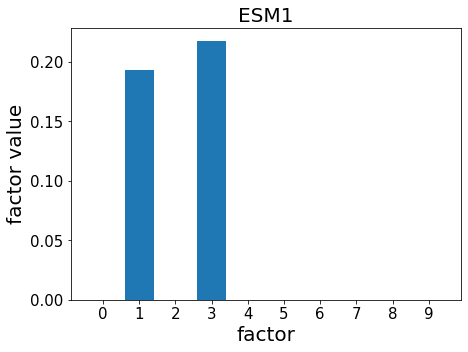

In [28]:
x_cpa1 = C_gene_hard.iloc[np.where(genes == "ESM1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[2].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("ESM1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/ESM1_hard.png", bbox_inches = "tight")

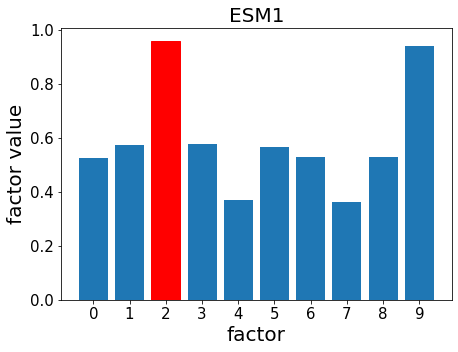

In [29]:
x_cpa1 = C_gene.iloc[np.where(genes == "ESM1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[2].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("ESM1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/ESM1.png", bbox_inches = "tight")

### Check marker gene for factor 5 (DUCTAL cell type)

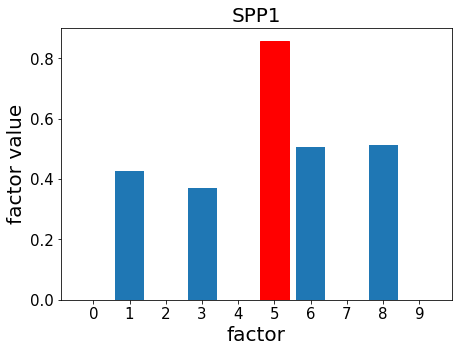

In [30]:
x_cpa1 = C_gene_hard.iloc[np.where(genes == "SPP1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[5].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("SPP1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/SPP1_hard.png", bbox_inches = "tight")

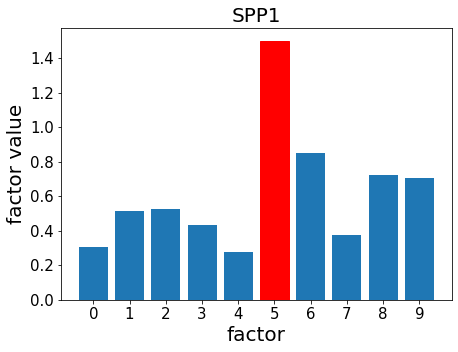

In [31]:
x_cpa1 = C_gene.iloc[np.where(genes == "SPP1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[5].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("SPP1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

fig.savefig("pancreas/plots/SPP1.png", bbox_inches = "tight")

In [32]:
def plot_gene(zs, feat = None, save = None, figsize = (20,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    axs = fig.subplots(len(zs),1)

    for batch in range(len(zs)):
        pic = axs[batch].scatter(zs[batch][:,0], zs[batch][:,1], c =  feat[batch], **_kwargs)        
        axs[batch].set_title("batch " + str(batch + 1), fontsize = 25)
        axs[batch].tick_params(axis = "both", which = "major", labelsize = 15)

        axs[batch].set_xlabel(axis_label + " 1", fontsize = 19)
        axs[batch].set_ylabel(axis_label + " 2", fontsize = 19)
        axs[batch].spines['right'].set_visible(False)
        axs[batch].spines['top'].set_visible(False)  
        cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = axs[batch])
        cbar.ax.tick_params(labelsize = 20)
        
        
    if save:
        fig.savefig(save, bbox_inches = "tight")


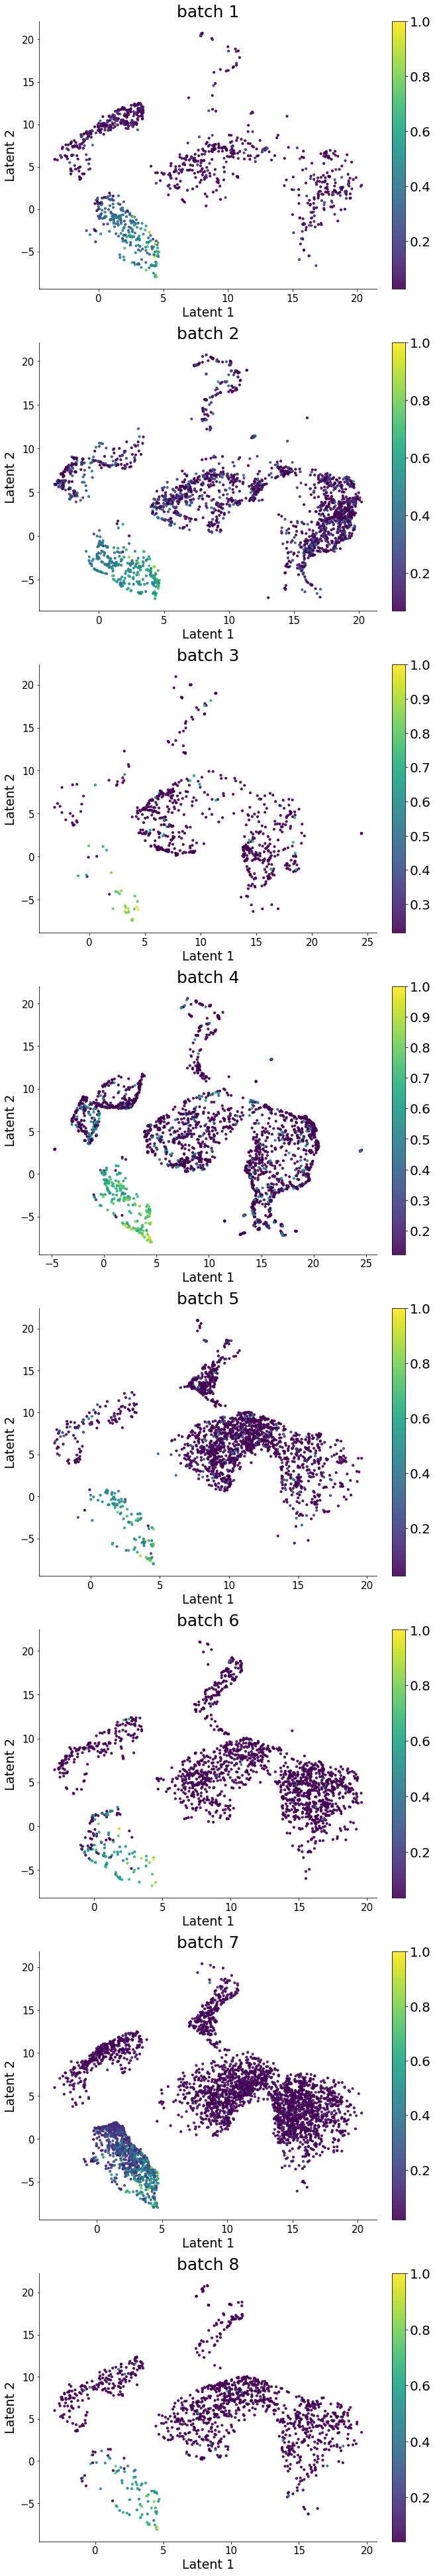

In [33]:
feats = [x[:, np.where(genes == "CPA1")].squeeze() for x in counts["rna"]]
plot_gene(x_umaps, feat = feats, save = "pancreas/umap_CPA1.png", figsize = (10,70), axis_label = "Latent")


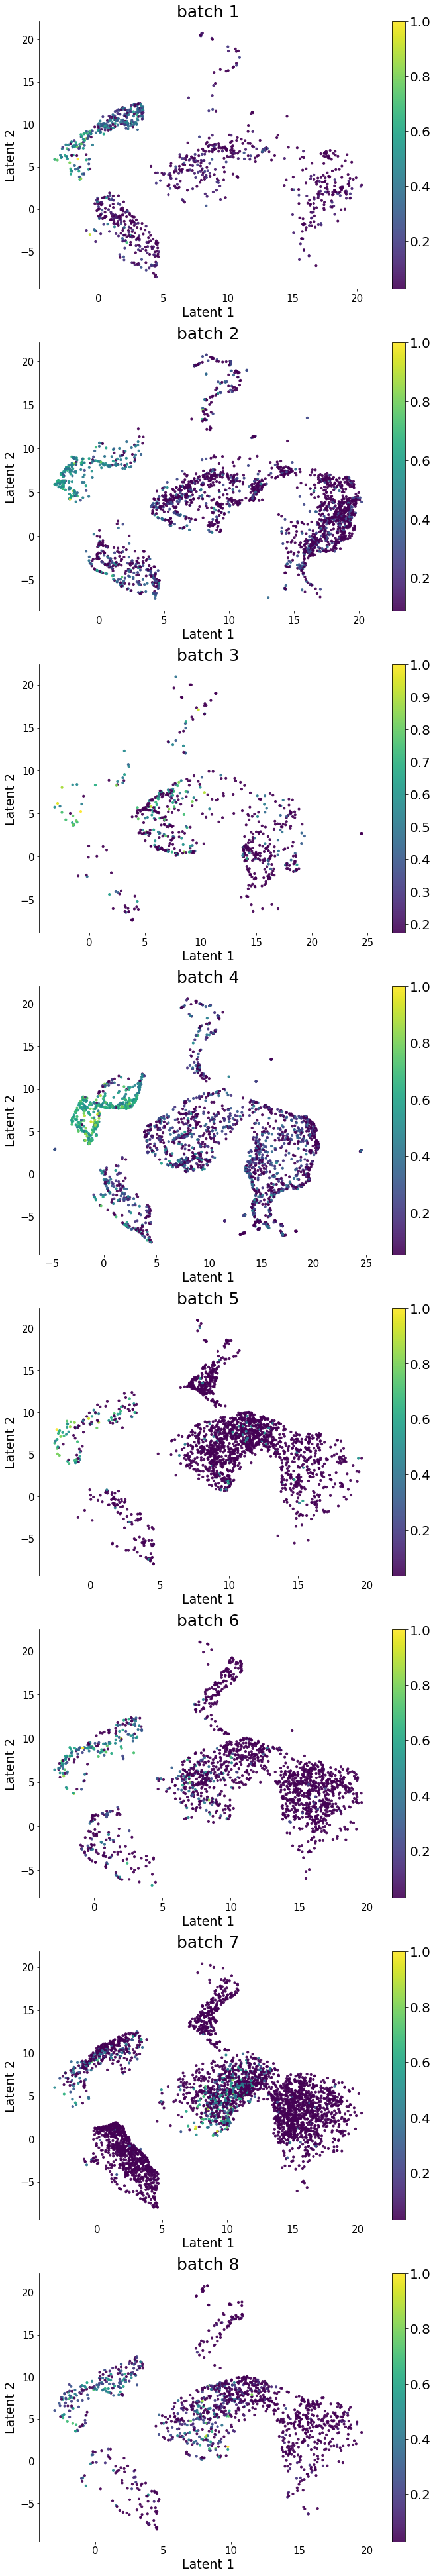

In [34]:
feats = [x[:, np.where(genes == "SPP1")].squeeze() for x in counts["rna"]]
plot_gene(x_umaps, feat = feats, save = "pancreas/umap_SPP1.png", figsize = (10,70), axis_label = "Latent")


### Marker gene of cluster 9 (DELTA cell type)

DELTA cell type is note well separated, mixed by cluster 8 and 9

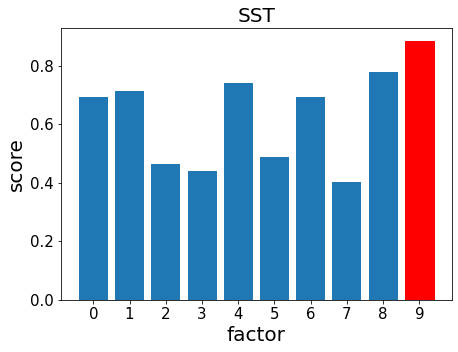

In [44]:
x_cpa1 = C_gene.iloc[np.where(genes == "SST")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[9].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("SST", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("score", fontsize = 20)



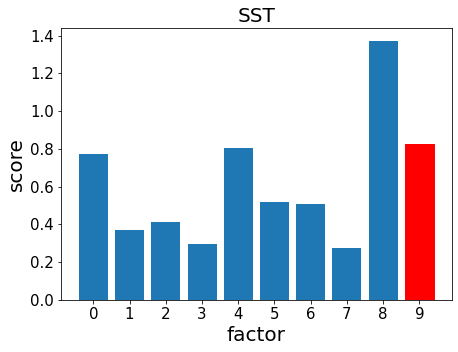

In [43]:
x_cpa1 = C_gene.iloc[np.where(genes == "RBP4")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[9].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("SST", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("score", fontsize = 20)


